Start complete streamflow-precipitation elasticity analysis
 Data Loading and Preprocessing
 Original data shape: (4346, 198)
 Shape after filtering: (4042, 198)
 Training set: (3233, 196), Test set: (809, 196)

 Target Variable Distribution Analysis


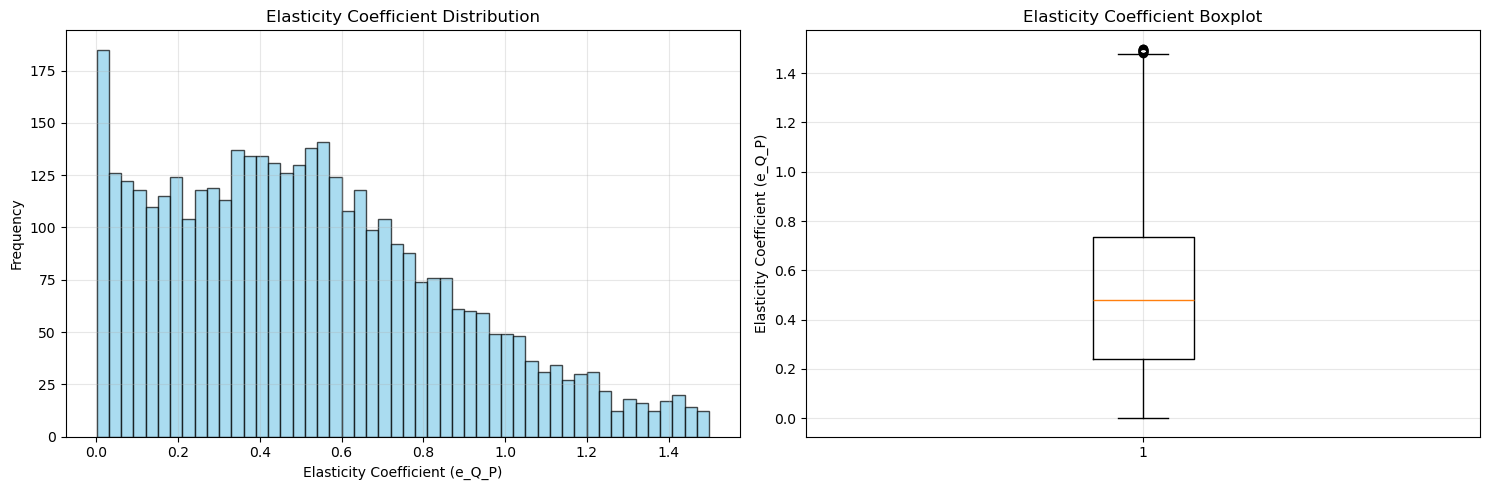

 Descriptive Statistics:
   Mean: 0.517
   Median: 0.481
   Std Dev: 0.344
   Min: 0.000
   Max: 1.499
   Skewness: 0.562

 Initial Feature Selection
 Top 30 important features selected:
    1. swc_pc_s06     : 0.2716
    2. run_mm_syr     : 0.1111
    3. cmi_ix_syr     : 0.0327
    4. slp_dg_sav     : 0.0302
    5. swc_pc_s05     : 0.0206
    6. ele_mt_smn     : 0.0164
    7. ari_ix_sav     : 0.0126
    8. hdi_ix_sav     : 0.0115
    9. swc_pc_s11     : 0.0084
   10. gdp_ud_sav     : 0.0079
   ... and 20 other features


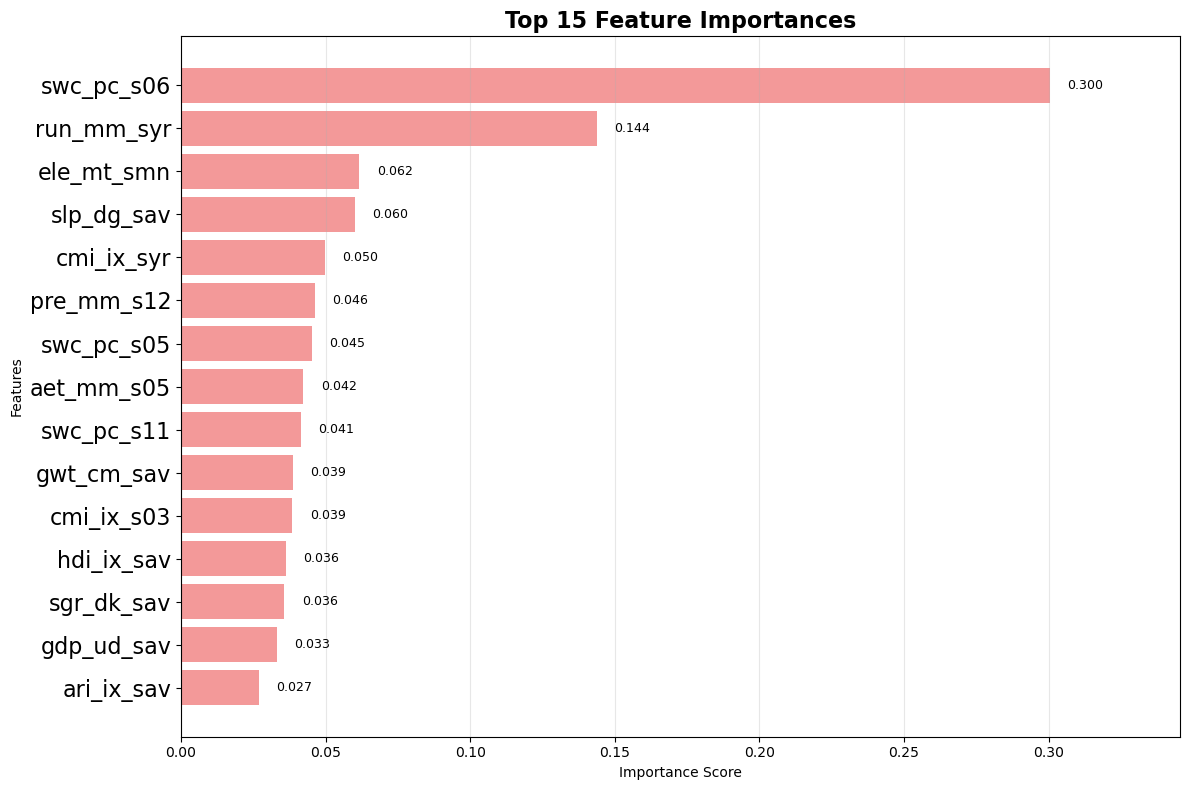


 Hyperparameter Optimization and Feature Selection

 Testing 10 features...
   CV R²: 0.5740
   Training R²: 0.7794
   Test R²: 0.5995
   Overfitting: 0.1799

 Testing 15 features...
   CV R²: 0.5820
   Training R²: 0.7857
   Test R²: 0.6114
   Overfitting: 0.1743

 Testing 20 features...
   CV R²: 0.5906
   Training R²: 0.8017
   Test R²: 0.6173
   Overfitting: 0.1843

 Testing 25 features...
   CV R²: 0.5949
   Training R²: 0.8101
   Test R²: 0.6214
   Overfitting: 0.1887

 Performance Comparison Across Different Feature Numbers:
   n_features   cv_r2  test_r2  overfitting
0          10  0.5740   0.5995       0.1799
1          15  0.5820   0.6114       0.1743
2          20  0.5906   0.6173       0.1843
3          25  0.5949   0.6214       0.1887

 Best Configuration:
   Number of features: 25
   Test R²: 0.6214
   Best hyperparameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 300}


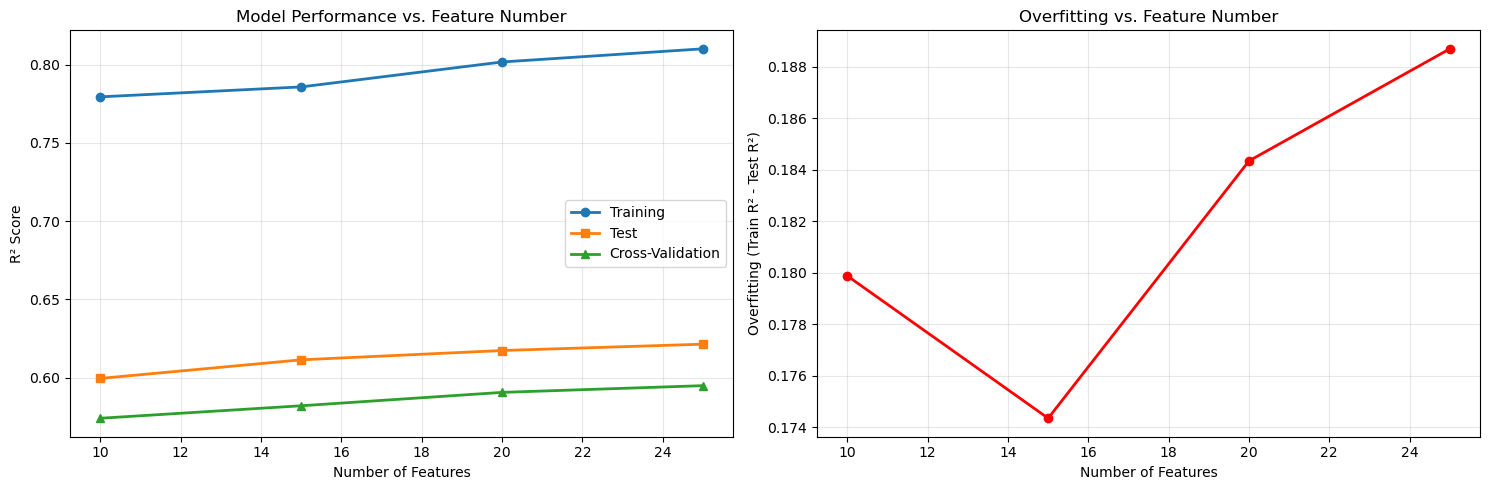


 Final Model Evaluation
 Model Performance Metrics:

Training:
   R²: 0.8101
   RMSE: 0.1502
   MAE: 0.1048

Test:
   R²: 0.6214
   RMSE: 0.2112
   MAE: 0.1515

10-fold Cross-Validation:
   Mean R²: 0.5954 ± 0.0409
   R² Range: [0.5330, 0.6448]


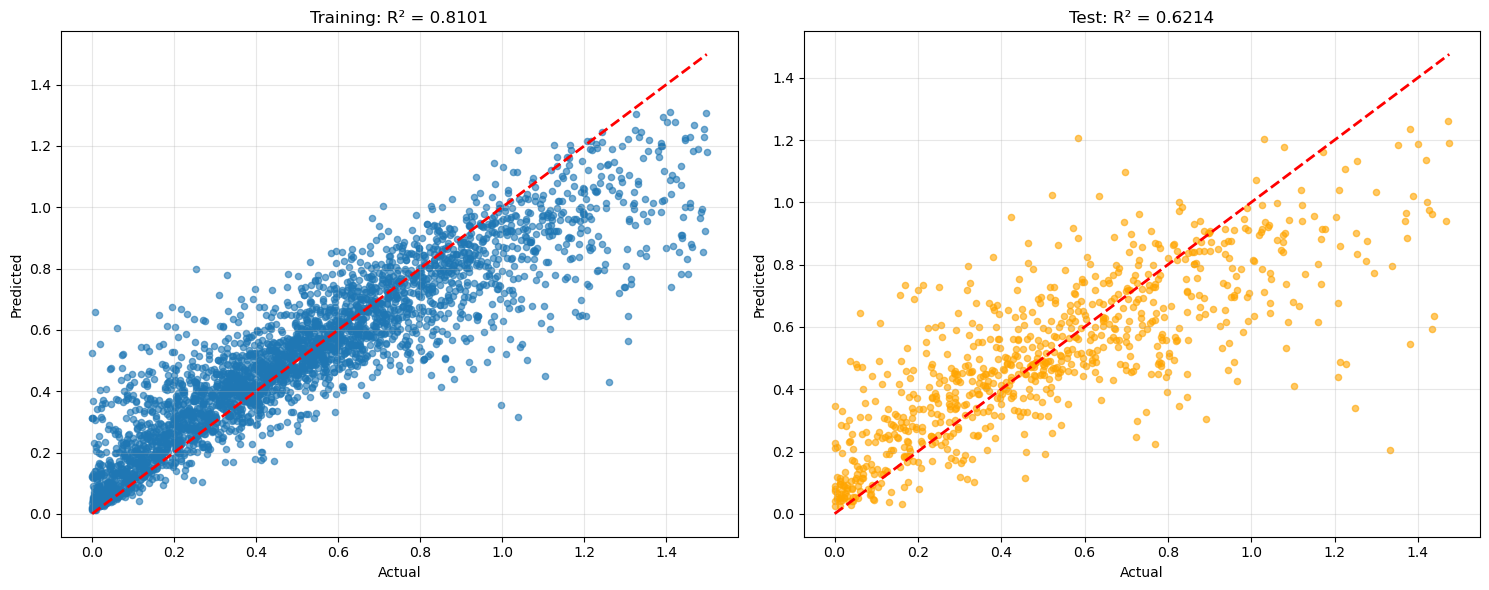


 In-depth analysis of feature importance
 Top 10 most important features:
    1. swc_pc_s06               : 0.1168
    2. run_mm_syr               : 0.1026
    7. ari_ix_sav               : 0.0866
    3. cmi_ix_syr               : 0.0803
    5. swc_pc_s05               : 0.0758
   24. swc_pc_s07               : 0.0577
    9. swc_pc_s11               : 0.0517
   17. cmi_ix_s04               : 0.0425
    4. slp_dg_sav               : 0.0415
   15. cmi_ix_s03               : 0.0333


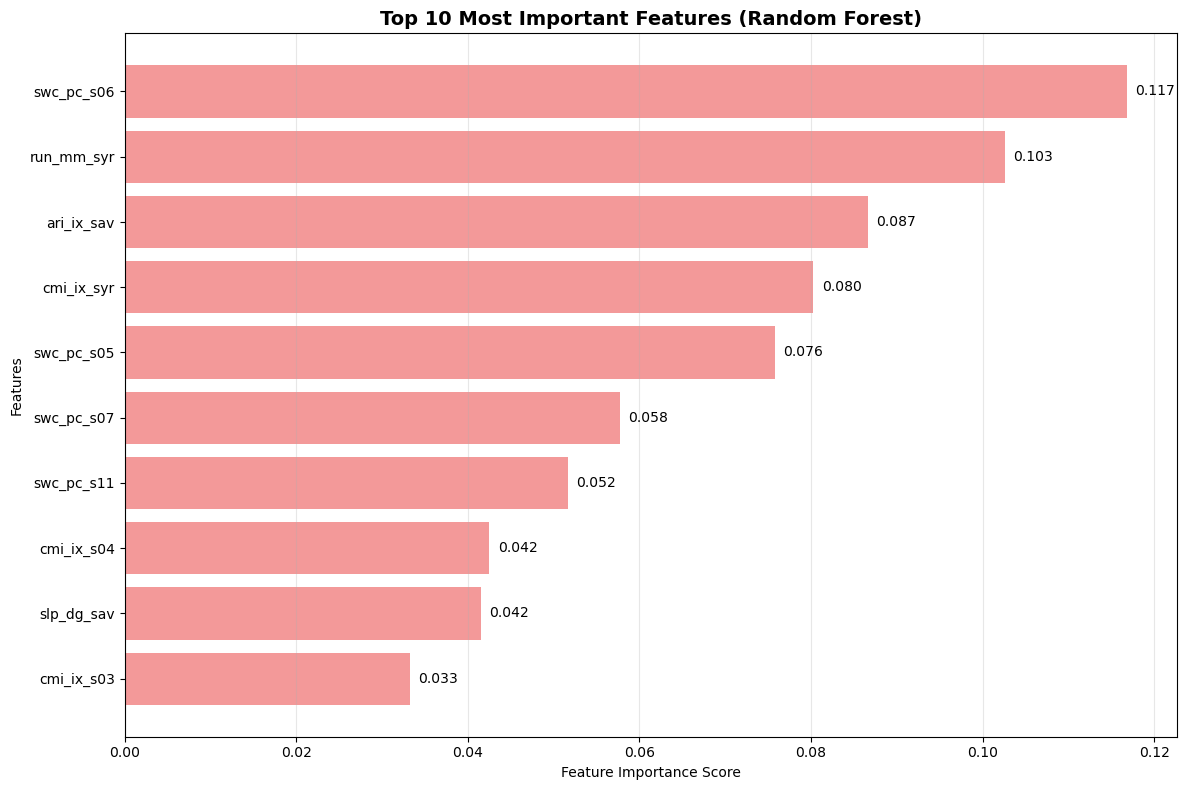


Physical Process Interpretation (Regex-based, leakage-safe)
Coverage audit (on FINAL selected features):
   Total selected features: 25
   Used after exclude_hydrology=True: 24
   Classified into known families: 23  (95.8%)
   Unclassified (need new rule or check naming): 1
   → Unclassified examples (top 1): ['gwt_cm_sav']

Importance by physical process (cumulative, Random Forest):
   • Soil_Water     : 0.3020
   • Climate        : 0.2642
   • Topography     : 0.0960
   • Precipitation  : 0.0689
   • Land_Cover     : 0.0643
   • Human_Impact   : 0.0637
   • Unclassified   : 0.0229
   • Soil_Properties: 0.0155


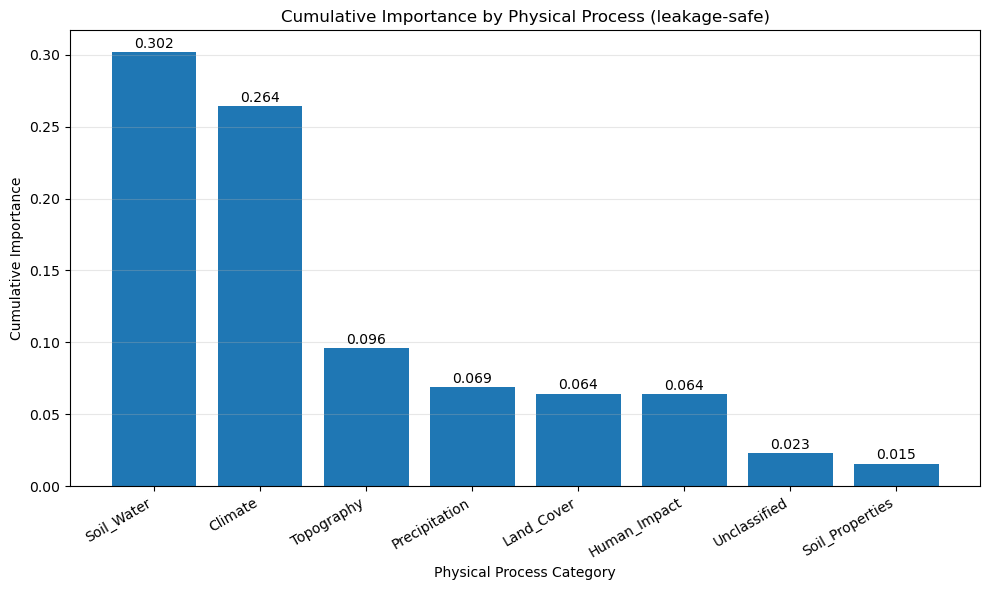


Top features by |importance| (after leakage-safe filtering):
   - swc_pc_s06  →  Soil_Water  (0.1168)
   - ari_ix_sav  →  Climate  (0.0866)
   - cmi_ix_syr  →  Climate  (0.0803)
   - swc_pc_s05  →  Soil_Water  (0.0758)
   - swc_pc_s07  →  Soil_Water  (0.0577)
   - swc_pc_s11  →  Soil_Water  (0.0517)
   - cmi_ix_s04  →  Climate  (0.0425)
   - slp_dg_sav  →  Topography  (0.0415)
   - cmi_ix_s03  →  Climate  (0.0333)
   - ele_mt_smn  →  Topography  (0.0282)

 Analysis completed!

Analysis summary:
Optimal number of features: 25
Test set R²: 0.6214
The most important physical processes: ['Soil_Water', 'Climate', 'Topography']


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings
import re
warnings.filterwarnings('ignore')


class StreamflowElasticityAnalysis:
    def __init__(self, data_path):
        """
        Initialize Streamflow-Precipitation Elasticity Analysis class
        """
        self.data_path = data_path
        self.data = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.best_model = None
        self.selected_features = None

    def load_and_preprocess_data(self, low_threshold=0, upper_threshold=1.5):
        """
        Load and preprocess data
        """
        print("=" * 60)
        print(" Data Loading and Preprocessing")
        print("=" * 60)

        # retrieve data
        self.data = pd.read_csv(self.data_path)
        print(f" Original data shape: {self.data.shape}")

        # filter outliers
        mask = (self.data.iloc[:, 1] >= low_threshold) & (self.data.iloc[:, 1] <= upper_threshold)
        self.data = self.data[mask]
        print(f" Shape after filtering: {self.data.shape}")

        # Separate features and target variable
        self.y = self.data.iloc[:, 1]  # e_Q_P
        self.X = self.data.iloc[:, 2:]  # all features

        # Check for missing values
        missing_cols = self.X.isnull().sum()
        if missing_cols.sum() > 0:
            print(f" Missing values found: {missing_cols[missing_cols > 0].sum()} ")
            # Remove columns with missing values
            self.X = self.X.dropna(axis=1)
            print(f" Number of features after removing missing values: {self.X.shape[1]}")

        # Train-test split
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=0.2, random_state=42, stratify=pd.qcut(self.y, q=5, duplicates='drop')
        )

        print(f" Training set: {self.X_train.shape}, Test set: {self.X_test.shape}")

    def explore_target_distribution(self):
        """
        Explore target variable distribution
        """
        print("\n" + "=" * 60)
        print(" Target Variable Distribution Analysis")
        print("=" * 60)

        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        # Original distribution
        axes[0].hist(self.y, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        axes[0].set_title('Elasticity Coefficient Distribution')
        axes[0].set_xlabel('Elasticity Coefficient (e_Q_P)')
        axes[0].set_ylabel('Frequency')
        axes[0].grid(True, alpha=0.3)

        # Summary statistics
        axes[1].boxplot(self.y)
        axes[1].set_title('Elasticity Coefficient Boxplot')
        axes[1].set_ylabel('Elasticity Coefficient (e_Q_P)')
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Print summary statistics
        print(f" Descriptive Statistics:")
        print(f"   Mean: {self.y.mean():.3f}")
        print(f"   Median: {self.y.median():.3f}")
        print(f"   Std Dev: {self.y.std():.3f}")
        print(f"   Min: {self.y.min():.3f}")
        print(f"   Max: {self.y.max():.3f}")
        print(f"   Skewness: {self.y.skew():.3f}")

    def initial_feature_selection(self, n_features=30):
        """
        Initial feature selection
        """
        print("\n" + "=" * 60)
        print(" Initial Feature Selection")
        print("=" * 60)

        # Initial feature selection using simple random forests
        rf_initial = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        rf_initial.fit(self.X_train, self.y_train)

        # Get feature importances
        importances = rf_initial.feature_importances_
        indices = importances.argsort()[::-1][:n_features]
        self.selected_features = self.X.columns[indices]

        print(f" Top {n_features} important features selected:")
        for i, feature in enumerate(self.selected_features[:10]): 
            print(f"   {i+1:2d}. {feature:15s}: {importances[indices[i]]:.4f}")
        if n_features > 10:
            print(f"   ... and {n_features-10} other features")

        return self.selected_features

    def plot_feature_importance(self, top_n=15):
        """
        Plot feature importance (horizontal bar chart)
        """
        if self.selected_features is None:
            print(" Please run feature selection first.")
            return

        top_n = min(top_n, len(self.selected_features))

        # Retrain the model to obtain significance (for visual checking only)
        rf_temp = RandomForestRegressor(n_estimators=100, random_state=42)
        X_selected = self.X_train[self.selected_features[:top_n]]
        rf_temp.fit(X_selected, self.y_train)

        importances = rf_temp.feature_importances_
        
        order = np.argsort(importances)[::-1][:top_n]

        imp_sorted = importances[order]
        feat_sorted = [self.selected_features[i] for i in order]

        plt.figure(figsize=(12, 8))
        plt.title(f'Top {top_n} Feature Importances', fontsize=16, fontweight='bold')

        y_pos = np.arange(top_n)
        bars = plt.barh(y_pos, imp_sorted, color='lightcoral', alpha=0.8)
        plt.yticks(y_pos, feat_sorted, fontsize=16)
        plt.xlabel('Importance Score')
        plt.ylabel('Features')

        
        plt.gca().invert_yaxis()

      
        x_pad = imp_sorted.max() * 0.02 if imp_sorted.max() > 0 else 0.002
        for i, v in enumerate(imp_sorted):
            plt.text(v + x_pad, i, f'{v:.3f}', va='center', ha='left', fontsize=9)

        plt.grid(axis='x', alpha=0.3)
        plt.xlim(0, imp_sorted.max() * 1.15 if imp_sorted.size else 1)
        plt.tight_layout()
        plt.show()


    def optimize_hyperparameters(self, n_features_list=[10, 15, 20, 25]):
        """
        Hyperparameter optimization and feature number selection
        """
        print("\n" + "=" * 60)
        print(" Hyperparameter Optimization and Feature Selection")
        print("=" * 60)

        best_score = -np.inf
        best_params = {}
        best_n_features = 0
        results = []

        # Define hyperparameter grid
        param_grid = {
            'n_estimators': [200, 300],
            'max_depth': [5, 10, 15],
            'min_samples_split': [10, 20],
            'min_samples_leaf': [5, 10],
            'max_features': ['sqrt', 0.2]
        }

        for n_feat in n_features_list:
            print(f"\n Testing {n_feat} features...")

            X_train_selected = self.X_train[self.selected_features[:n_feat]]
            X_test_selected = self.X_test[self.selected_features[:n_feat]]

            # Grid search
            rf = RandomForestRegressor(random_state=42, n_jobs=-1)
            grid_search = GridSearchCV(
                rf, param_grid, cv=5,
                scoring='r2', n_jobs=-1, verbose=0
            )

            grid_search.fit(X_train_selected, self.y_train)

            # Evaluating Performance
            train_score = grid_search.score(X_train_selected, self.y_train)
            test_score = grid_search.score(X_test_selected, self.y_test)
            cv_score = grid_search.best_score_

            results.append({
                'n_features': n_feat,
                'train_r2': train_score,
                'test_r2': test_score,
                'cv_r2': cv_score,
                'overfitting': train_score - test_score,
                'best_params': grid_search.best_params_
            })

            print(f"   CV R²: {cv_score:.4f}")
            print(f"   Training R²: {train_score:.4f}")
            print(f"   Test R²: {test_score:.4f}")
            print(f"   Overfitting: {train_score - test_score:.4f}")

            
            if test_score > best_score:
                best_score = test_score
                best_params = grid_search.best_params_
                best_n_features = n_feat
                self.best_model = grid_search.best_estimator_

        # Display results comparison
        results_df = pd.DataFrame(results)
        print("\n Performance Comparison Across Different Feature Numbers:")
        print(results_df[['n_features', 'cv_r2', 'test_r2', 'overfitting']].round(4))

        print(f"\n Best Configuration:")
        print(f"   Number of features: {best_n_features}")
        print(f"   Test R²: {best_score:.4f}")
        print(f"   Best hyperparameters: {best_params}")

        # Plotting performance comparisons
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        # R² Comparison
        axes[0].plot(results_df['n_features'], results_df['train_r2'], 'o-', label='Training', linewidth=2)
        axes[0].plot(results_df['n_features'], results_df['test_r2'], 's-', label='Test', linewidth=2)
        axes[0].plot(results_df['n_features'], results_df['cv_r2'], '^-', label='Cross-Validation', linewidth=2)
        axes[0].set_xlabel('Number of Features')
        axes[0].set_ylabel('R² Score')
        axes[0].set_title('Model Performance vs. Feature Number')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # Overfitting degree
        axes[1].plot(results_df['n_features'], results_df['overfitting'], 'ro-', linewidth=2)
        axes[1].set_xlabel('Number of Features')
        axes[1].set_ylabel('Overfitting (Train R² - Test R²)')
        axes[1].set_title('Overfitting vs. Feature Number')
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        return best_n_features, best_params

    def final_model_evaluation(self, best_n_features):
        """
        Final model evaluation
        """
        print("\n" + "=" * 60)
        print(" Final Model Evaluation")
        print("=" * 60)

        X_train_final = self.X_train[self.selected_features[:best_n_features]]
        X_test_final = self.X_test[self.selected_features[:best_n_features]]

        y_train_pred = self.best_model.predict(X_train_final)
        y_test_pred = self.best_model.predict(X_test_final)

        metrics = {
            'Training': {
                'R²': r2_score(self.y_train, y_train_pred),
                'RMSE': np.sqrt(mean_squared_error(self.y_train, y_train_pred)),
                'MAE': mean_absolute_error(self.y_train, y_train_pred)
            },
            'Test': {
                'R²': r2_score(self.y_test, y_test_pred),
                'RMSE': np.sqrt(mean_squared_error(self.y_test, y_test_pred)),
                'MAE': mean_absolute_error(self.y_test, y_test_pred)
            }
        }

        # cross-validation
        cv_scores = cross_val_score(self.best_model, X_train_final, self.y_train, cv=10, scoring='r2')

        print(" Model Performance Metrics:")
        for dataset, scores in metrics.items():
            print(f"\n{dataset}:")
            for metric, value in scores.items():
                print(f"   {metric}: {value:.4f}")

        print(f"\n10-fold Cross-Validation:")
        print(f"   Mean R²: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
        print(f"   R² Range: [{cv_scores.min():.4f}, {cv_scores.max():.4f}]")

        # Plotting predicted vs. actual values
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))

        # training set
        axes[0].scatter(self.y_train, y_train_pred, alpha=0.6, s=20)
        axes[0].plot([self.y_train.min(), self.y_train.max()],
                     [self.y_train.min(), self.y_train.max()], 'r--', lw=2)
        axes[0].set_xlabel('Actual')
        axes[0].set_ylabel('Predicted')
        axes[0].set_title(f'Training: R² = {metrics["Training"]["R²"]:.4f}')
        axes[0].grid(True, alpha=0.3)

        # test set
        axes[1].scatter(self.y_test, y_test_pred, alpha=0.6, s=20, color='orange')
        axes[1].plot([self.y_test.min(), self.y_test.max()],
                     [self.y_test.min(), self.y_test.max()], 'r--', lw=2)
        axes[1].set_xlabel('Actual')
        axes[1].set_ylabel('Predicted')
        axes[1].set_title(f'Test: R² = {metrics["Test"]["R²"]:.4f}')
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        return metrics

    def analyze_feature_importance(self, best_n_features, top_n=10):
        """
        Analyze feature importance (simplified)
        """
        print("\n" + "=" * 60)
        print(" In-depth analysis of feature importance")
        print("=" * 60)

        # Importance of features built-in using random forests
        feature_importance = self.best_model.feature_importances_

        importance_df = pd.DataFrame({
            'feature': self.selected_features[:best_n_features],
            'importance': feature_importance
        })

        # Sort by importance
        importance_df = importance_df.sort_values('importance', ascending=False)

        print(f" Top {top_n} most important features:")
        for i, row in importance_df.head(top_n).iterrows():
            print(f"   {i+1:2d}. {row['feature']:25s}: {row['importance']:.4f}")

        # Mapping the significance of features
        plt.figure(figsize=(12, 8))
        top_features = importance_df.head(top_n)

        # horizontal bar chart
        bars = plt.barh(range(top_n), top_features['importance'], color='lightcoral', alpha=0.8)
        plt.yticks(range(top_n), top_features['feature'])
        plt.xlabel('Feature Importance Score')
        plt.ylabel('Features')
        plt.title(f'Top {top_n} Most Important Features (Random Forest)', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3, axis='x')
        plt.gca().invert_yaxis()

        # Adding numeric labels
        for i, bar in enumerate(bars):
            plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
                     f'{top_features.iloc[i]["importance"]:.3f}',
                     ha='left', va='center', fontsize=10)

        plt.tight_layout()
        plt.show()

        return importance_df

    def physical_interpretation(self, importance_df, top_n=10, exclude_hydrology=True, show_uncovered_top=20):
        """
        Physical process interpretation (regex-driven, leakage-safe).
        """
        print("\n" + "=" * 60)
        print("Physical Process Interpretation (Regex-based, leakage-safe)")
        print("=" * 60)

        # Mapping of naming rules to physical process categories
        category_regex = {
            'Climate': [r'^cmi_', r'^ari_', r'^aet_mm_', r'^pet_mm_', r'^tmp_', r'^tmx_', r'^tmn_', r'^snw_pc_'],
            'Precipitation': [r'^pre_mm_'],
            'Soil_Water': [r'^swc_pc_'],
            'Topography': [r'^ele_', r'^slp_', r'^sgr_'],
            'Land_Cover': [r'^(for|crp|urb|gla|pac|pst)_pc_', r'^glc_pc_', r'^pnv_pc_', r'^wet_pc_'],
            'Soil_Properties': [r'^(cly|slt|snd|soc)_', r'^lit_cl_', r'^kar_pc_', r'^ero_kh_'],
            'Human_Impact': [r'^(gdp|hdi|pop|ppd|rdd|nli|hft)_'],
            # The Hydrology class is excluded from the explanation by default to avoid information leakage.
            'Hydrology': [r'^dis_m3_', r'^run_mm_', r'^riv_tc_', r'^rev_mc_', r'^lkv_mc_']
        }

        def assign_category(name: str):
            for cat, patterns in category_regex.items():
                for pat in patterns:
                    if re.search(pat, name):
                        return cat
            return 'Unclassified'

        hydrology_pats = category_regex['Hydrology']
        def is_hydrology(name: str):
            return any(re.search(p, name) for p in hydrology_pats)

        # Maps features by rule; excludes Hydrology-derived features if required
        mapped_rows = []
        for _, row in importance_df.iterrows():
            f = row['feature']
            imp = float(row['importance'])
            if exclude_hydrology and is_hydrology(f):
                continue
            mapped_rows.append((f, imp, assign_category(f)))

        if not mapped_rows:
            print(" After excluding hydrology, nothing left to interpret. Consider setting exclude_hydrology=False.")
            return {}

        mapped_df = pd.DataFrame(mapped_rows, columns=['feature', 'importance', 'category'])

        total_selected = len(importance_df)
        used_after_exclude = mapped_df['feature'].nunique()
        n_unclassified = (mapped_df['category'] == 'Unclassified').sum()
        covered = used_after_exclude - n_unclassified
        coverage_pct = covered / used_after_exclude * 100 if used_after_exclude > 0 else 0.0

        print("Coverage audit (on FINAL selected features):")
        print(f"   Total selected features: {total_selected}")
        print(f"   Used after exclude_hydrology={exclude_hydrology}: {used_after_exclude}")
        print(f"   Classified into known families: {covered}  ({coverage_pct:.1f}%)")
        print(f"   Unclassified (need new rule or check naming): {n_unclassified}")
        if n_unclassified > 0:
            sample = mapped_df[mapped_df['category'] == 'Unclassified']['feature'].head(show_uncovered_top).tolist()
            print(f"   → Unclassified examples (top {min(show_uncovered_top, n_unclassified)}): {sample}")


        cl_code_cols = [f for f in mapped_df['feature'] if f.endswith('_cl_smj')]
        if cl_code_cols:
            print(" Note: *_cl_smj fields are categorical codes (majority class). One-hot encoding is recommended.")

        # Cumulative importance by category and mapping
        agg = mapped_df.groupby('category', as_index=False)['importance'].sum()
        agg = agg.sort_values('importance', ascending=False)

        print("\nImportance by physical process (cumulative, Random Forest):")
        for _, r in agg.iterrows():
            print(f"   • {r['category']:<15s}: {r['importance']:.4f}")

        plt.figure(figsize=(10, 6))
        bars = plt.bar(agg['category'], agg['importance'])
        plt.xlabel('Physical Process Category')
        plt.ylabel('Cumulative Importance')
        plt.title('Cumulative Importance by Physical Process (leakage-safe)')
        plt.xticks(rotation=30, ha='right')
        for b, v in zip(bars, agg['importance']):
            plt.text(b.get_x() + b.get_width()/2, v + 0.001, f"{v:.3f}", ha='center', va='bottom')
        plt.tight_layout()
        plt.grid(True, axis='y', alpha=0.3)
        plt.show()

        # Top-N Details List (Filtered)
        top_feats = mapped_df.sort_values('importance', ascending=False).head(top_n)
        print("\nTop features by |importance| (after leakage-safe filtering):")
        for _, r in top_feats.iterrows():
            print(f"   - {r['feature']}  →  {r['category']}  ({r['importance']:.4f})")

        categorized_features = {}
        for _, r in top_feats.iterrows():
            categorized_features.setdefault(r['category'], []).append(r['feature'])

        return categorized_features

    def run_complete_analysis(self):
        """
        Run the complete analysis pipeline
        """
        print("Start complete streamflow-precipitation elasticity analysis")
        print("=" * 80)

        # 1. Data loading and pre-processing
        self.load_and_preprocess_data()

        # 2. Target variable distribution exploration
        self.explore_target_distribution()

        # 3. Initial feature selection
        self.initial_feature_selection(n_features=30)

        # 4. Plot feature importance (for verification)
        self.plot_feature_importance(top_n=15)

        # 5. Hyperparameter optimization
        best_n_features, best_params = self.optimize_hyperparameters()

        # 6. Final model evaluation
        metrics = self.final_model_evaluation(best_n_features)

        # 7. Feature importance analysis (formal)
        importance_df = self.analyze_feature_importance(best_n_features)

        # 8. Physical process interpretation
        categorized_features = self.physical_interpretation(importance_df)

        print("\n" + "=" * 80)
        print(" Analysis completed!")
        print("=" * 80)

        return {
            'best_model': self.best_model,
            'best_n_features': best_n_features,
            'best_params': best_params,
            'metrics': metrics,
            'importance_df': importance_df,
            'categorized_features': categorized_features
        }


if __name__ == "__main__":
    # Create analysis instance
    analyzer = StreamflowElasticityAnalysis("final_eQP_prediction_dataset.csv")

    # Run complete analysis
    results = analyzer.run_complete_analysis()

    print("\nAnalysis summary:")
    print(f"Optimal number of features: {results['best_n_features']}")
    print(f"Test set R²: {results['metrics']['Test']['R²']:.4f}")
    print(f"The most important physical processes: {list(results['categorized_features'].keys())}")
